## Self-Driving Car Engineer Nanodegree

### Project: Advanced Lane Lines

***
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

------

#### Initial Imports


In [1]:
import cv2
import os 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import glob 

#### Useful functions for the project

In [2]:
# Correcting distortion 
def cal_undistort(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    # Camera Calibration 
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    # Undistorted Image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


# Sobel Threshold 
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    if orient is 'x': 
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    elif orient is 'y': 
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))

    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    

    # 6) Return this mask as your binary_output image
    binary_output = sxbinary
    
    return binary_output

# S Threshold 
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    # 3) Return a binary image of threshold result
    return binary_output


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    return histogram

def find_lane_pixels(binary_warped, nwindows=9, margin=100, minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
       
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window
        # (`right` or `leftx_current`) on their mean position 
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped, nwindows, margin, minpix):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, nwindows, margin, minpix)

    # Fit a second order polynomial to each using `np.polyfit` 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]


    return out_img, left_fitx, right_fitx, ploty

def calculate_curv(binary_warped, nwindows, margin, minpix): 
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
       
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window
        # (`right` or `leftx_current`) on their mean position 
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each using `np.polyfit` 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    y_eval = binary_warped.shape[0] - 1 # position at which curvature is calculated
    left_curverad = (1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5 / np.absolute(2*left_fit_cr[0])
    right_curverad = (1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5 / np.absolute(2*right_fit_cr[0])
    
    
    # Calculate offset of car assuming dashcam is mounted at car centerline
    offset_val = xm_per_pix * 0.5 * (binary_warped.shape[1] - (leftx_base + rightx_base))

        
    return left_curverad, right_curverad, offset_val
    
    
def lane_lines_road(Minv, wraped_image, test_img_und, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(wraped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    # Combine the result with the original image
    out_road = cv2.addWeighted(test_img_und, 1, newwarp, 0.3, 0)
    
    return out_road

#### Camera Calibration 

Extract object and image points for camera calibration. 

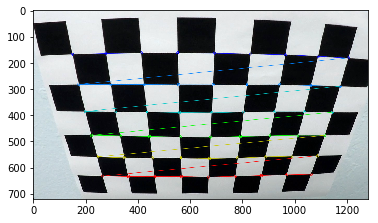

In [3]:
# Prepare object points 
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Chessboard size 
chess_size = [9, 6]

# Step through the list and search for chessboard corners
for fname in images:
    # Read image
    img = cv2.imread(fname)

    # Set image to gray scale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chess_size[0], chess_size[1]), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (chess_size[0], chess_size[1]), corners, ret)
    
        # Save image
        base = os.path.basename(fname)
        img_name = os.path.splitext(base)[0]
        cv2.imwrite('./output_images/%s-out.jpg'%(img_name), img)
        plt.imshow(img)




Testing undistortion on an example image (#3).  

True

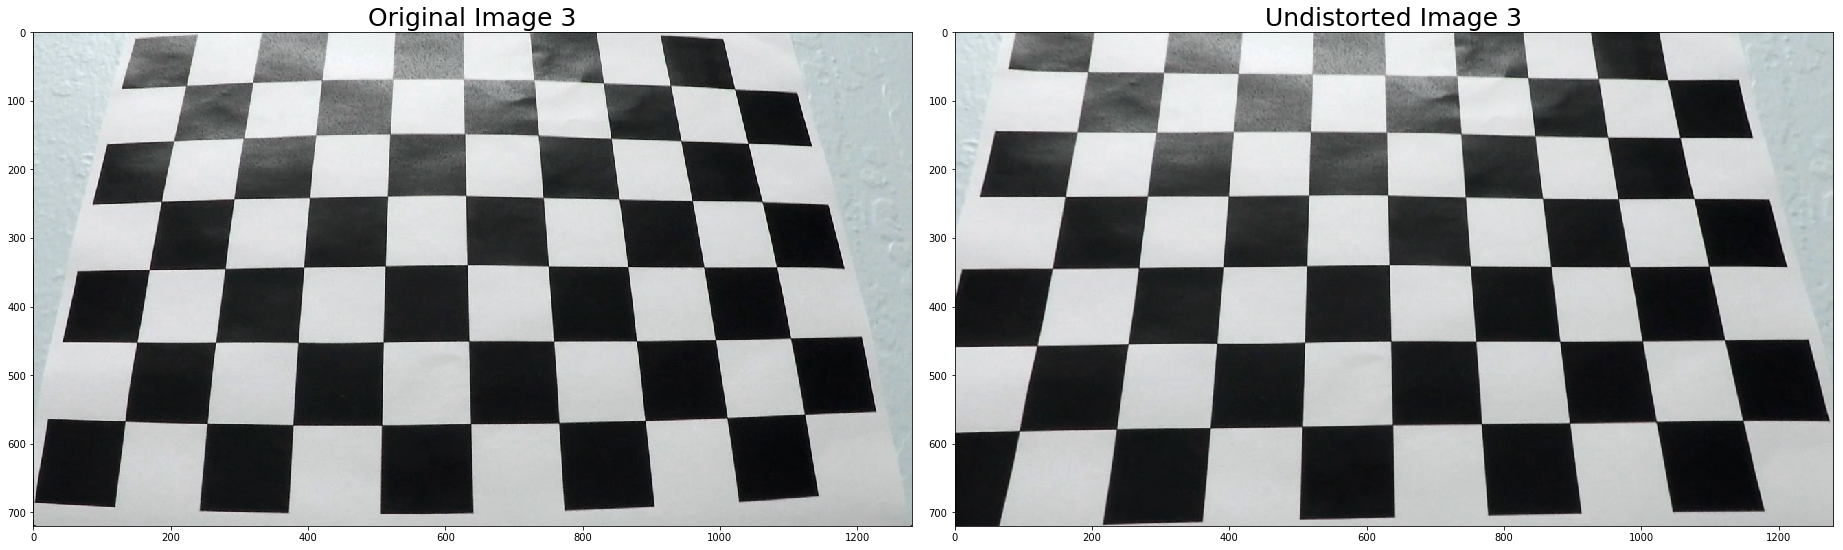

In [4]:
# Import test image 
test_img = cv2.imread('./camera_cal/calibration3.jpg')

# Apply undistortion
test_img_und = cal_undistort(test_img, objpoints, imgpoints)

# Visualize undistortion 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image 3', fontsize=25)
ax2.imshow(test_img_und)
ax2.set_title('Undistorted Image 3', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Save example image 
cv2.imwrite('./output_images/calibration3-undistorted-out.jpg', test_img_und)

#### Pipeline (single image)

Undistorted image. Example with test image #1. 

True

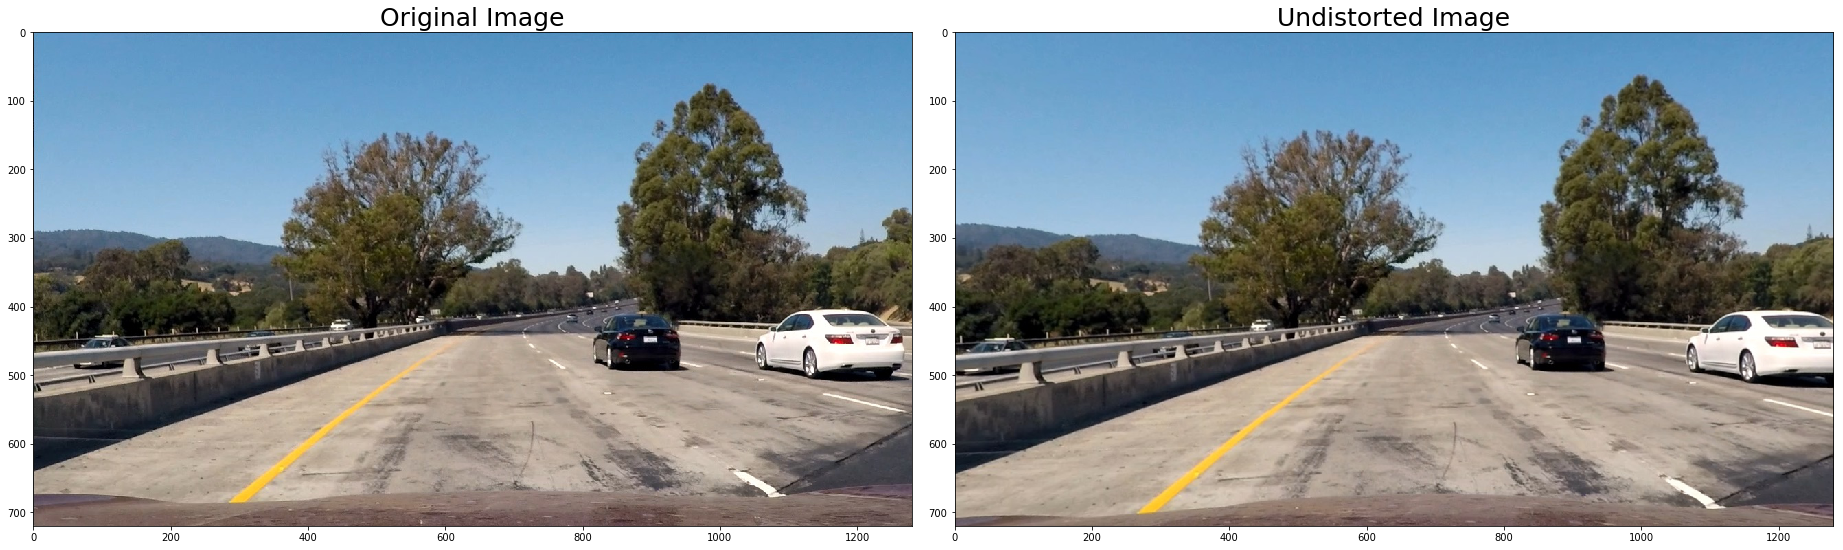

In [5]:
# Import test image
test_image = mpimg.imread('./test_images/test1.jpg') 

# Apply undistortion
test_img_und = cal_undistort(test_image, objpoints, imgpoints)

# Visualize undistortion 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(test_img_und)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Save example image 
cv2.imwrite('./output_images/test1-undistorted-out.jpg', test_img_und)

Obtain a threshold binary image.

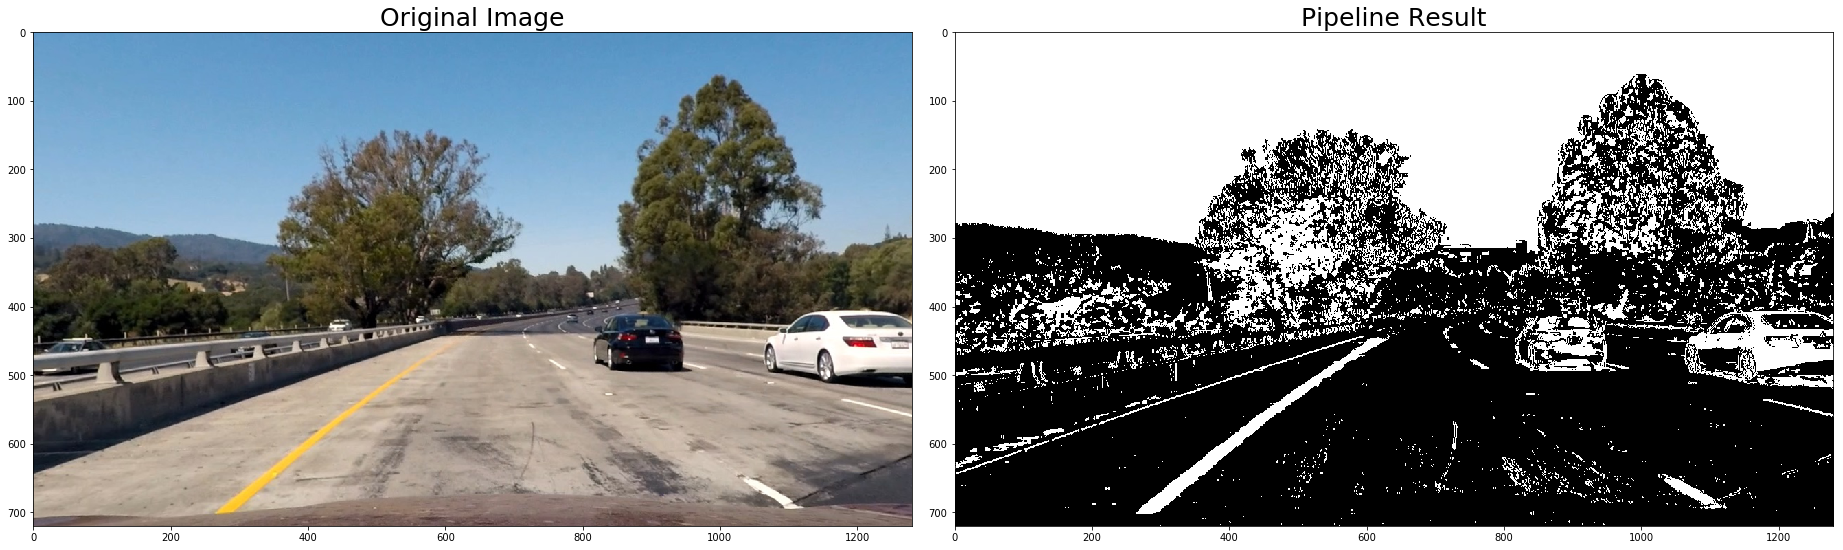

In [6]:
test_image = test_img_und

# Apply thresholding functions 
# 1. Sobel
grad_x = abs_sobel_thresh(test_image, orient='x', thresh_min=20, thresh_max=100)

# 2. S
s_binary = hls_select(test_image, thresh=(90, 255))

# Combining Thresholds
combined_image = np.zeros_like(grad_x)
combined_image[((grad_x == 1) | (s_binary == 1))] = 1

# Visualize result 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()

ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=25)

ax2.imshow(combined_image, cmap ='gray')
ax2.set_title('Pipeline Result', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Obtain prespective transform. 

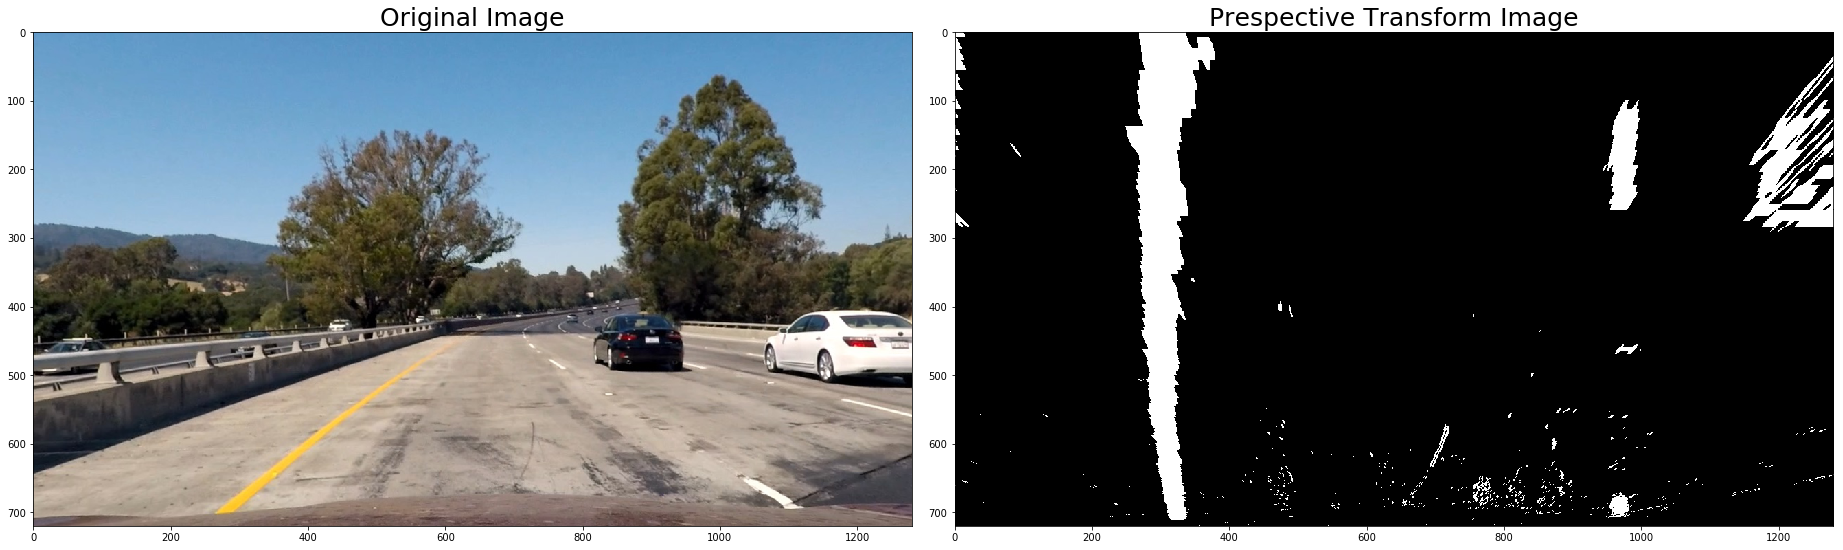

In [7]:
test_image = test_img_und
image = combined_image 

# Prespective Transform
# Source Points
src = np.float32([[585,470], [245,720], [1145, 720],[735,470]])
# Destination Points
dst = np.float32([[320,0], [320,720], [960, 720],[960,0]])

img_size = (image.shape[1], image.shape[0])

# Get transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Get top-down view
wraped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)


# Visualize result 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(wraped, cmap ='gray')
ax2.set_title('Prespective Transform Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Identify lane-line pixels and fit their positions with a polynomial. 

Text(0.5,1,'Identified Lane Lines')

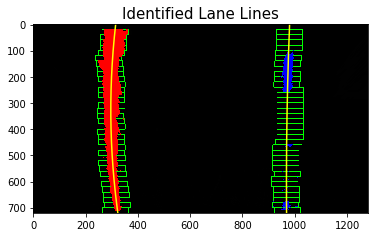

In [8]:
wraped_image = wraped

# Set HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 35
# Set the width of the windows +/- margin
margin = 50
# Set minimum number of pixels found to recenter window
minpix = 20

# Finding lane pixels and fitting it with polynomial
out_img, left_fitx, right_fitx, ploty = fit_polynomial(wraped_image, nwindows, margin, minpix)

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

# Visualize result
plt.imshow(out_img)
plt.title('Identified Lane Lines', fontsize=15)

Find radius of curvature and offset of vehicle from lane centreline. 

In [9]:
left_curverad, right_curverad, offset_val = calculate_curv(wraped_image, nwindows, margin, minpix)
radius = (left_curverad + right_curverad)/2

# Direction followed 
if offset_val < 0:
    offset_dir = 'left'
else:
    offset_dir = 'right'

print('Curvature radius: ' + str(radius))
print('Car offset: ' + str(offset_val) + ' >> The vehicle is moving towards ' + str(offset_dir) + '.')

Curvature radius: 2959.5670736
Car offset: -0.0185 >> The vehicle is moving towards left.


Plot indentified line lanes in the original image. 

Text(0.5,1,'Identified Lane Lines down to road')

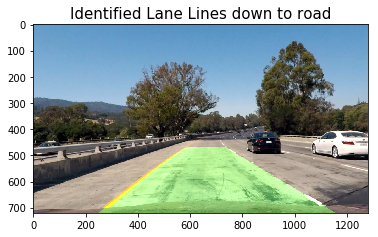

In [10]:
# Find the identified area and down it to the road 
out_road = lane_lines_road(Minv, wraped_image, test_img_und, left_fitx, right_fitx, ploty)

# Visualize the result 
plt.imshow(out_road)
plt.title('Identified Lane Lines down to road', fontsize=15)

#### Pipeline (video)

Identify line lanes during a video. 

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(image, obj_points=objpoints, img_points=imgpoints, nwindows=35, margin=50, minpix=20):
    # Undistort image 
    test_img_und = cal_undistort(image, obj_points, img_points)
    
    # Apply thresholding functions 
    # 1. Sobel
    grad_x = abs_sobel_thresh(test_img_und, orient='x', thresh_min=20, thresh_max=100)

    # 2. S
    s_binary = hls_select(test_image, thresh=(90, 255))

    # Combining Thresholds
    combined_image = np.zeros_like(grad_x)
    combined_image[((grad_x == 1) | (s_binary == 1))] = 1
    
    # Prespective Transform
    # Source Points
    src = np.float32([[585,470], [245,720], [1145, 720],[735,470]])
    # Destination Points
    dst = np.float32([[320,0], [320,720], [960, 720],[960,0]])

    img_size = (combined_image.shape[1], combined_image.shape[0])

    # Get transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Get top-down view
    wraped = cv2.warpPerspective(combined_image, M, img_size, flags=cv2.INTER_LINEAR)

    # Finding lane pixels and fitting it with polynomial
    out_img, left_fitx, right_fitx, ploty = fit_polynomial(wraped_image, nwindows, margin, minpix)
    
    # Find the indentified area and down it to the road 
    out_road = lane_lines_road(Minv, wraped_image, test_img_und, left_fitx, right_fitx, ploty)
    
    return out_road

In [ ]:
video_output = './output_images/project_video_out.mp4'
#clip1 = VideoFileClip('./project_video.mp4').subclip(0,5)
clip1 = VideoFileClip('./project_video.mp4')
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_images/project_video_out.mp4
[MoviePy] Writing video ./output_images/project_video_out.mp4


100%|█████████▉| 1260/1261 [32:36<00:01,  1.53s/it]


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))